### **Library Imports**

In [1]:
import os
import re
import cv2
import torch
import random as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torchvision import models, transforms

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

### **Helpers**

In [2]:
SEED = 42
SIZE = 512
le = LabelEncoder()

def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")


def show_loss_graphs(L: list) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure()
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.show()

    
def show_accuracy_graphs(A: list) -> None:
    TA, VA = [], []
    for i in range(len(A)):
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])
    x_Axis = np.arange(1, len(TA) + 1)
    plt.figure()
    plt.plot(x_Axis, TA, "r", label="Train")
    plt.plot(x_Axis, VA, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Accuracy Graph")
    plt.show()

    
def show_lr_graph(LR: list) -> None:
    x_Axis = [i+1 for i in range(len(LR))]
    plt.figure(figsize=(8, 6))
    plt.plot(x_Axis, LR, "rx")
    plt.grid()
    plt.show()

### **Configuration**

In [3]:
class CFG(object):
    def __init__(self, 
                 seed: int = 42,
                 in_channels: int = 3,
                 size: int = 224,
                 n_splits: int = 5,
                 batch_size: int = 16,
                 epochs: int = 25,
                 early_stopping: int = 5,
                 lr: float = 1e-4,
                 wd: float = 0.0,
                 max_lr: float = 1e-3,
                 pct_start: float = 0.2,
                 steps_per_epoch: int = 100,
                 div_factor: int = 1e3, 
                 final_div_factor: float = 1e3,
                 ):
        self.seed = seed
        self.in_channels = in_channels
        self.size = size
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.lr = lr
        self.wd = wd
        self.max_lr = max_lr
        self.pct_start = pct_start
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.46708, 0.53804, 0.56547],
                                                     [0.22706, 0.24302, 0.26072]),
                                ])
        self.train_path = "../input/rsd-analysis"
        self.save_path = "saves"
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
    
cfg = CFG(seed=SEED, size=SIZE)

### **Dataset Template**

In [4]:
class DS(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray, bboxes: np.ndarray, transform=None):
        self.transform = transform
        self.images = images
        self.labels = labels
        self.bboxes = bboxes
    
    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.transform(self.images[idx]), \
               torch.LongTensor(self.labels[idx]), \
               torch.FloatTensor(self.bboxes[idx])

### **Model**

In [5]:
class Model(nn.Module):
    def __init__(self, in_channels: int = 3):
        super(Model, self).__init__()

        self.features = models.resnet50(pretrained=True, progress=True)
        self.freeze()
        self.features = nn.Sequential(*[*self.features.children()][:-1])
        
        self.classifier = nn.Linear(in_features=self.features[-2][-1].bn3.num_features, out_features=4)
        self.regressor = nn.Linear(in_features=self.features[-2][-1].bn3.num_features, out_features=4)
    
    def freeze(self):
        for params in self.parameters(): params.requires_grad = False
    
    def forward(self, x):
        x = nn.Flatten()(self.features(x))
        cls_op = nn.LogSoftmax(dim=1)(self.classifier(x))
        reg_op = self.regressor(x)
        
        return cls_op, reg_op

### **Fit**

In [6]:
def fit(model=None, 
        optimizer=None,
        scheduler_rlrop=None,
        scheduler_oclr=None, 
        epochs=None, 
        early_stopping_patience=None, 
        dataloaders=None, 
        fold=None, 
        device=None,
        save_path=None,
        verbose=False) -> tuple:
    
    def get_accuracy(y_pred, y_true):
        y_pred = torch.argmax(y_pred, dim=1)
        return torch.count_nonzero(y_pred == y_true).item() / len(y_pred)
    
    if verbose:
        breaker()
        if fold: print(f"Training Fold {fold}...")
        else: print("Training ...")
        breaker()
        
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    bestAccs = {"train" : 0.0, "valid" : 0.0}
    
    Losses, Accuracies, LRs = [], [], []
    
    if fold: name = f"state_fold_{fold}.pt"
    else: name = "state.pt"

    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss = {"train" : 0.0, "valid" : 0.0}
        epochAccs = {"train" : 0.0, "valid" : 0.0}


        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
    
            lossPerPass = []
            accsPerPass = []
            
            for images, labels, bboxes in dataloaders[phase]:
                images, labels, bboxes = images.to(device), labels.view(-1).to(device), bboxes.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    op_CLS, op_REG = model(images)
                    
                    # print(f"\nNLL - {torch.nn.NLLLoss()(op_CLS, labels)}")
                    # print(f"MSE - {torch.nn.MSELoss()(op_REG, bboxes)}\n")

                    loss = torch.nn.NLLLoss()(op_CLS, labels) + torch.nn.MSELoss()(op_REG, bboxes)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        if scheduler_oclr: scheduler_oclr.step()
                lossPerPass.append(loss.item())
                accsPerPass.append(get_accuracy(op_CLS, labels))
            epochLoss[phase] = np.mean(np.array(lossPerPass))
            epochAccs[phase] = np.mean(np.array(accsPerPass))
        Losses.append(epochLoss)
        Accuracies.append(epochAccs)
        
        if scheduler_oclr:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_oclr.state_dict()}
        
        elif scheduler_rlrop:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_rlrop.state_dict()}
        
        else:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict()}
            
        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save(save_dict, os.path.join(save_path, name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save(save_dict, os.path.join(save_path, name))
        
        if epochAccs["valid"] > bestAccs["valid"]:
            bestAccs = epochAccs
            BAE = e + 1
            # torch.save(save_dict, os.path.join(save_path, name))
        
        if scheduler_rlrop: scheduler_rlrop.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} |\
 Train Accs: {:.5f} | Valid Accs: {:.5f} | Time: {:.2f} seconds".format(e+1, 
                                                                        epochLoss["train"], epochLoss["valid"], 
                                                                        epochAccs["train"], epochAccs["valid"], 
                                                                        time()-e_st))

    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print(f"Best Validation Accs at Epoch {BAE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    
    return Losses, Accuracies, LRs, BLE, BAE, name

### **Train**

In [7]:
images = np.load(os.path.join(cfg.train_path, f"images_{SIZE}.npy"))

df = pd.read_csv(os.path.join(cfg.train_path, "data.csv"))
labels = df.labels.copy().values
labels = le.fit_transform(labels)
bboxes = np.concatenate((
    df.x1.copy().values.reshape(-1, 1),
    df.y1.copy().values.reshape(-1, 1),
    df.x2.copy().values.reshape(-1, 1),
    df.y2.copy().values.reshape(-1, 1),
), axis=1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]


**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.06926 | Valid Loss: 0.82350 | Train Accs: 0.67373 | Valid Accs: 0.79545 | Time: 19.54 seconds
Epoch: 2 | Train Loss: 0.84736 | Valid Loss: 0.66221 | Train Accs: 0.71460 | Valid Accs: 0.79545 | Time: 12.51 seconds
Epoch: 3 | Train Loss: 0.74499 | Valid Loss: 0.65868 | Train Accs: 0.78059 | Valid Accs: 0.82955 | Time: 12.41 seconds
Epoch: 4 | Train Loss: 0.70867 | Valid Loss: 0.54499 | Train Accs: 0.76224 | Valid Accs: 0.84659 | Time: 12.71 seconds
Epoch: 5 | Train Loss: 0.63827 | Valid Loss: 0.52130 | Train Accs: 0.77852 | Valid Accs: 0.84091 | Time: 12.46 seconds
Epoch: 6 | Train Loss: 0.57622 | Valid Loss: 0.51335 | Train Accs: 0.80441 | Valid Accs: 0.82955 | Time: 12.59 seconds
Epoch: 7 | Train Loss: 0.56494 | Valid Loss: 0.60489 | Train Accs: 0.80791 | Valid Accs: 0.83523 | Time: 12.19 seconds
Epoch: 8 | Train Loss: 0.58459 | Valid Loss: 0.5

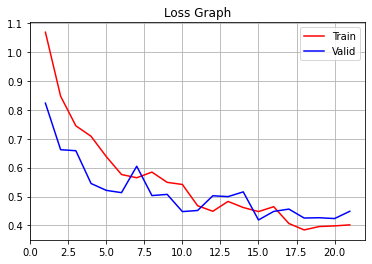


**************************************************



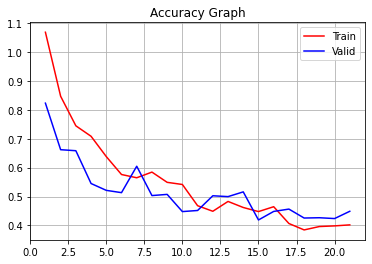


**************************************************



In [8]:
for tr_idx, va_idx in StratifiedKFold(n_splits=cfg.n_splits, random_state=cfg.seed, shuffle=True).split(images, labels):
    break

tr_images, va_images, tr_labels, va_labels, tr_bboxes, va_bboxes = images[tr_idx], images[va_idx], labels[tr_idx], labels[va_idx], bboxes[tr_idx], bboxes[va_idx]

tr_data_setup = DS(tr_images, tr_labels.reshape(-1, 1), tr_bboxes, cfg.transform)
va_data_setup = DS(va_images, va_labels.reshape(-1, 1), va_bboxes, cfg.transform)

dataloaders = {
    "train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(cfg.seed)),
    "valid" : DL(va_data_setup, batch_size=cfg.batch_size, shuffle=False),
}

cfg = CFG(
    seed=SEED, 
    size=SIZE, 
    epochs=50, 
    batch_size=64, 
    early_stopping=5, 
    lr=1e-3, 
    wd=0.0, 
    steps_per_epoch=len(dataloaders["train"])
)

torch.manual_seed(cfg.seed)
model = Model().to(cfg.device)

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
# optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)

# scheduler_oclr = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, 
#                                                max_lr=cfg.max_lr, 
#                                                epochs=cfg.epochs, 
#                                                steps_per_epoch=cfg.steps_per_epoch,
#                                                pct_start=cfg.pct_start, 
#                                                div_factor=cfg.div_factor, 
#                                                final_div_factor=cfg.final_div_factor)
# scheduler_rlrop = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
#                                                        patience=cfg.patience,
#                                                        eps=cfg.eps,
#                                                        verbose=True)

scheduler_oclr = None
scheduler_rlrop = None

L, A, LRs, BLE, BAE, name = fit(model=model, 
                                optimizer=optimizer, 
                                scheduler_oclr=scheduler_oclr, 
                                scheduler_rlrop=scheduler_rlrop, 
                                epochs=cfg.epochs, 
                                early_stopping_patience=cfg.early_stopping, 
                                dataloaders=dataloaders, 
                                device=cfg.device,
                                save_path=cfg.save_path,
                                verbose=True)

breaker()
show_loss_graphs(L)
breaker()
show_accuracy_graphs(L)
breaker()

if scheduler_oclr:
    x_Axis = [i+1 for i in range(len(LRs))]
    plt.figure(figsize=(8, 6))
    plt.plot(x_Axis, LRs, "rx")
    plt.grid()
    plt.show()
    breaker()

### **Predictions**

In [9]:
def get_image(path: str) -> np.ndarray:
    return cv2.cvtColor(src=cv2.imread(path), code=cv2.COLOR_BGR2RGB)


def show_image(image: np.ndarray) -> None:
    plt.figure()
    plt.imshow(image)
    plt.axis("off")
    plt.show()


def draw_bboxes(image: np.ndarray, x1: int, y1: int, x2: int, y2: int) -> None:
    cv2.rectangle(img=image, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=2)


def predict(model=None, device=None, image=None, size=None, path=None) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)    
    model.eval()
    
    h, w, _ = image.shape
    temp_image = cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)

    with torch.no_grad(): 
        op_CLS, op_REG = model(transforms.ToTensor()(temp_image).unsqueeze(dim=0).to(device))
    
    op_CLS = torch.argmax(torch.exp(op_CLS), dim=1).item()
    op_REG = op_REG.detach().cpu().numpy().squeeze()
    
    return op_CLS, op_REG


**************************************************



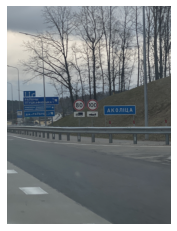


**************************************************



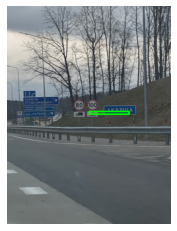


**************************************************

Label : speedlimit

**************************************************



/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
index = r.randint(0, df.shape[0]-1)
image = get_image(f"../input/road-sign-detection/images/{df.filenames[index]}")

breaker()
show_image(image)

label, bboxes = predict(Model(), cfg.device, image, 512, "./saves/state.pt")

h, w, _ = image.shape

x1 = int(bboxes[0] * w)
y1 = int(bboxes[1] * h)
x2 = int(bboxes[2] * w)
y2 = int(bboxes[3] * h)

draw_bboxes(image, x1, y1, x2, y2)

breaker()
show_image(image)

breaker()
print(f"Label : {le.inverse_transform(np.array(label).reshape(-1, 1))[0]}")
breaker()